In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.nn import Parameter
import sys
sys.path.append('../')
import probtorch
from probtorch.util import expand_inputs
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+f9f5c9b torch: 0.4.1 cuda: True


## ProbTorch

* Probtorch is an extension of Pytroch for deep generative models
* Intended to be like Pytorch as much as possible
* Models in ProbTorch are written just like in PyTorch but with three additional constructs
    * A library of reparametrized distributions avaliable in Pytorch
    * A Trace datastructue to instantiate and store random variable
    * Objective function that approximate the lower bound on the log-marginal likelihood

### Drawing sample from unit Normal 

In [4]:
loc = 0.   # mean zero
scale = 1. # unit variance

In [38]:
q = probtorch.Trace()
x = q.normal(loc = loc, scale = scale, name = 'my_sample')
print("sample", x)
print(q)

sample tensor(1.1958)
Trace{'my_sample': Normal([torch.FloatTensor of size ])}


## Simple Model 

Let’s suppose we have a bunch of data with daily mean temperatures and cloud cover. We want to reason about how temperature interacts with whether it was sunny or cloudy. A simple stochastic function that does that is given by:

In [43]:
def weather():
    q = probtorch.Trace()
    cloudy = q.relaxed_bernoulli(0,0.3, name = 'cloudy')
    cloudy = 'cloudy' if cloudy == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = q.normal(loc = mean_temp, scale = scale_temp, name = 'temp')
    return cloudy, temp

for _ in range(3):
    print(weather())


('cloudy', tensor(48.4629))
('cloudy', tensor(70.0119))
('cloudy', tensor(68.4070))


In [28]:
def ice_cream_sales():
    q = probtorch.Trace()
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
#     ice_cream = pyro.sample('ice_cream', dist.Normal(expected_sales, 10.0))
    ice_cream = q.normal(loc = expected_sales, scale = 10.0)
    return ice_cream

In [29]:
ice_cream_sales()

tensor(34.9885)

## Stochastic Recursion, Higher-order Stochastic Functions, and Random Control Flow 

* We saw that Pyro can handle non-determistic termination in recusion and random control flow

In [45]:
def geometric(p, q, t=None):
    
    if t is None:
        t = 0
        
#     x = pyro.sample("x_{}".format(t), dist.Bernoulli(p))
    x = q.relaxed_bernoulli(0,p, name = 'x_{}'.format(t))
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, q, t + 1)

q = probtorch.Trace()
print(geometric(0.1, q))
print(q)

7
Trace{'x_0': RelaxedBernoulli([torch.FloatTensor of size ]), 'x_1': RelaxedBernoulli([torch.FloatTensor of size ]), 'x_2': RelaxedBernoulli([torch.FloatTensor of size ]), 'x_3': RelaxedBernoulli([torch.FloatTensor of size ]), 'x_4': RelaxedBernoulli([torch.FloatTensor of size ]), 'x_5': RelaxedBernoulli([torch.FloatTensor of size ]), 'x_6': RelaxedBernoulli([torch.FloatTensor of size ]), 'x_7': RelaxedBernoulli([torch.FloatTensor of size ])}


* Stochastic functions that accept as input or produce as output other stochastic functions:

In [37]:
def normal_product(q, loc, scale):
#     z1 = pyro.sample("z1", dist.Normal(loc, scale))
    z1 = q.normal(loc, scale)
#     z2 = pyro.sample("z2", dist.Normal(loc, scale))
    z2 = q.normal(loc, scale)
    y = z1 * z2
    return y

def make_normal_normal(q):
#     mu_latent = pyro.sample("mu_latent", dist.Normal(0, 1))
    mu_latent = q.normal(loc = 0, scale = 1)
    fn = lambda scale: normal_product(q,mu_latent, scale)
    return fn

q = probtorch.Trace()
print(make_normal_normal(q)(3.))
print(q)

tensor(-1.3099)
Trace{'normal_0': Normal([torch.FloatTensor of size ]), 'normal_1': Normal([torch.FloatTensor of size ]), 'normal_2': Normal([torch.FloatTensor of size ])}


# Inference 

* You have an object of which you want to measure the weight
* You have a weighing machine with is unreliable

In [46]:
def scale(q, guess):
    # The prior over weight encodes our uncertainty about our guess
#     weight = pyro.sample("weight", dist.Normal(guess, 1))
    
    weight = q.normal(loc = guess, scale= 1, name = 'weight')
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
#     return pyro.sample("measurement", dist.Normal(weight, 0.75))
    return q.normal(loc = weight, scale = 0.75, name = 'measurement')

* Suppose we want to get an estimate of the object weight using this model
* This involves marginializing followed by sampling

In [47]:
posterior = pyro.infer.Importance(scale, num_samples=100)

In [48]:
guess = 8.5

marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess))
print(marginal())

tensor(7.6722)


* `marginal` first uses posterior to genereate weighted execution traces
* Builds a histogram over return values
* Samples from this histogram

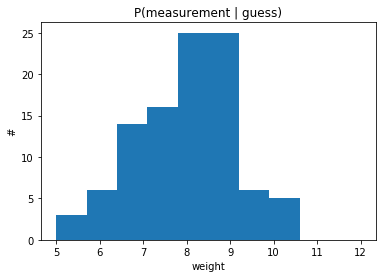

In [49]:
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#");

# Conditioning on Data (Observe)

* Given observed data we want to infer the latent factors that could have generated it
* `pyro.condition` allows to constrain the value of sample statements

In [50]:
# Takes as input
# 1. Model
# 2. Dictionary containing the observed values
conditioned_scale = pyro.condition(
    scale, data={"measurement": 9.5})
# returns a new model 
# Has same input and output signatures but always uses the given values at observed sample statements

In [51]:
def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={"measurement": measurement})(*args, **kwargs)

### Passing observed value directly to sample statement

In [52]:
# `obs` keyword is reserved for this purpose
def scale_obs(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
     # here we attach an observation measurement == 9.5
    return pyro.sample("measurement", dist.Normal(weight, 1.),
                       obs=9.5)

* Hardcoding is not recomended due to non-compositional nature

In [53]:
def scale2(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    tolerance = torch.abs(pyro.sample("tolerance", dist.Normal(0., 1.)))
    return pyro.sample("measurement", dist.Normal(weight, tolerance))

# conditioning composes:
# the following are all equivalent and do not interfere with each other
conditioned_scale2_1 = pyro.condition(
    pyro.condition(scale2, data={"weight": 9.2}),
    data={"measurement": 9.5})

conditioned_scale2_2 = pyro.condition(
    pyro.condition(scale2, data={"measurement": 9.5}),
    data={"weight": 9.2})

conditioned_scale2_3 = pyro.condition(
    scale2, data={"weight": 9.2, "measurement": 9.5})

## Flexible Approximate Inference With Guide Functions 

tensor(8.0129)


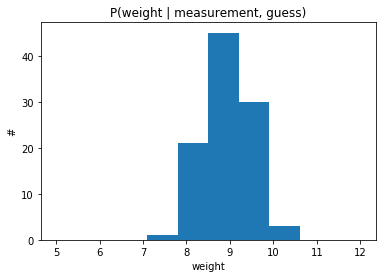

In [54]:
guess = 8.5
measurement = 9.5

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})

marginal = pyro.infer.EmpiricalMarginal(
    pyro.infer.Importance(conditioned_scale, num_samples=100).run(guess), sites="weight")
# When site is specified marginal will compute the marginal distribution of that site, 
#rather than of the return value

# The marginal distribution concentrates around the data
print(marginal())
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

* The above set up is inefficient because the prior distribution over `weigths` may be very far from true distribution depending on the intial value of `guess`
* Pryo supports arbitrary stochastic functions, guide function/guides, as approximate posterior dist
* Pyro eforces that *guide* and *model* have the same **call signature**
* The names of sample statements are used to align random variables in the model and the guide

In [55]:
def scale_prior_guide(guess):
    return pyro.sample("weight", dist.Normal(guess, 1.))

posterior = pyro.infer.Importance(conditioned_scale,
                                  guide=scale_prior_guide,
                                  num_samples=10)

marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess), sites="weight")

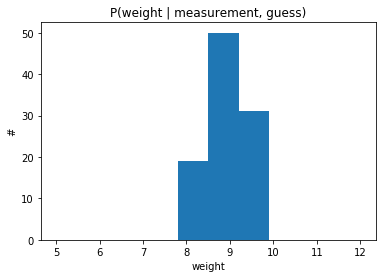

In [56]:
def scale_posterior_guide(measurement, guess):
    # note that torch.size(measurement, 0) is the total number of measurements
    # that we're conditioning on
    a = (guess + torch.sum(measurement)) / (measurement.size(0) + 1.0)
    b = 1. / (measurement.size(0) + 1.0)
    return pyro.sample("weight", dist.Normal(a, b))

posterior = pyro.infer.Importance(deferred_conditioned_scale,
                                  guide=scale_posterior_guide,
                                  num_samples=20)

marginal = pyro.infer.EmpiricalMarginal(posterior.run(torch.tensor([measurement]), guess), sites="weight")
plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

## Variational Inference 

* in general it is intractable to specify a guide that is a good approximation to the posterior distribution of an arbitrary conditioned stochastic function
* `pyro.param` can be used to specify a family of guides indexed by named parameters and search for the member of that family that is the best approximation
* We can use `pyro.param` to parametrize `a` and `b` instead of specifying them by hand

In [57]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(torch.randn(1) + guess))
    b = pyro.param("b", torch.randn(1))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

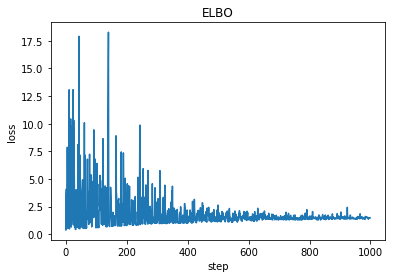

In [58]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001}),
                     loss=pyro.infer.Trace_ELBO())

losses = []
for t in range(1000):
    losses.append(svi.step(guess))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

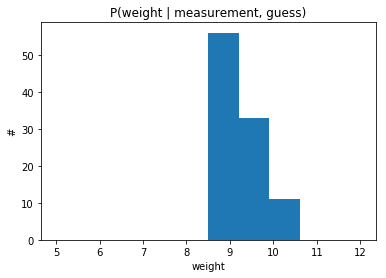

In [59]:
posterior = pyro.infer.Importance(conditioned_scale, scale_parametrized_guide, num_samples=10)
marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess), sites="weight")

plt.hist([marginal().item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

* We can also sample from the guide directly as an approximate posterior:

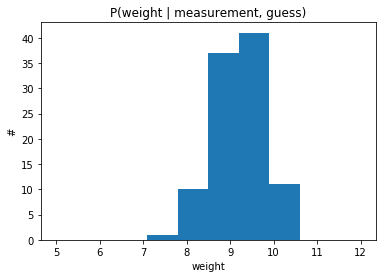

In [60]:
plt.hist([scale_parametrized_guide(guess).item() for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#");

# Variational Auto Encoder 

In [61]:
import os

import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [62]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [63]:
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = dset.MNIST(root=root, train=True, transform=trans,
                           download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [64]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

In [65]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [34]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.iarange("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).independent(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.iarange("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [66]:
vae = VAE()

In [67]:
optimizer = Adam({"lr": 1.0e-3})

In [68]:
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [69]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [70]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [71]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 100
TEST_FREQUENCY = 5

In [72]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

Processing...
Done!
[epoch 000]  average training loss: 191.0216
[epoch 000] average test loss: 156.0872
[epoch 001]  average training loss: 146.8141
[epoch 002]  average training loss: 133.2540
[epoch 003]  average training loss: 124.6775
[epoch 004]  average training loss: 119.5152
[epoch 005]  average training loss: 116.1240
[epoch 005] average test loss: 113.7908
[epoch 006]  average training loss: 113.7285
[epoch 007]  average training loss: 112.0445
[epoch 008]  average training loss: 110.7292
[epoch 009]  average training loss: 109.7455
[epoch 010]  average training loss: 108.9070
[epoch 010] average test loss: 107.7720
[epoch 011]  average training loss: 108.2513
[epoch 012]  average training loss: 107.6953
[epoch 013]  average training loss: 107.2849
[epoch 014]  average training loss: 106.8870
[epoch 015]  average training loss: 106.4983
[epoch 015] average test loss: 105.9786
[epoch 016]  average training loss: 106.1872
[epoch 017]  average training loss: 105.9363
[epoch 018